In [1]:
import numpy as np
import pandas as pd
import h5py
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [2]:
if torch.cuda.is_available():
    dev = "cuda:0"
    print("running on GPU")
else:
    print("running on CPU")
    dev = "cpu"
    
device = torch.device(dev)

running on CPU


In [3]:
df_training = pd.read_hdf('./NSubjetiness_TopData/train_subjettiness.h5', key='table')
df_val = pd.read_hdf('./NSubjetiness_TopData/val_subjettiness.h5', key='table')
df_test = pd.read_hdf('./NSubjetiness_TopData/test_subjettiness.h5', key='table')
keys = df_training.keys()

In [4]:
mean_values = []
std_values = []
for k in range(27):
    mean_values.append(np.mean(df_training[keys[k]]))
    std_values.append(np.std(df_training[keys[k]]))
    df_training[keys[k]] = (df_training[keys[k]] - mean_values[k]) / std_values[k]
    df_val[keys[k]] = (df_val[keys[k]] - mean_values[k]) / std_values[k]
    df_test[keys[k]] = (df_test[keys[k]] - mean_values[k]) / std_values[k]

In [5]:
def removeNaN(df):
    rm_ind = []
    for i in range(len(df)):
        if(i % 5000 == 0):
            print(i / len(df) * 100)
        for j in range(len(keys)):
            if not df.iloc[i][j] == df.iloc[i][j]:
                print("yes", i, j)
                rm_ind.append(i)
    if len(rm_ind) > 0:
        df.drop(df.index[rm_ind], inplace=True)

In [6]:
#removeNaN(df_training)
#removeNaN(df_val)
#removeNaN(df_test)

In [7]:
df_training.drop(df_training.index[456856], inplace=True)
df_val.drop(df_val.index[199765], inplace=True)

In [8]:
print(keys)

Index(['1_subjettiness_0.5', '1_subjettiness_1.0', '1_subjettiness_2.0',
       '2_subjettiness_0.5', '2_subjettiness_1.0', '2_subjettiness_2.0',
       '3_subjettiness_0.5', '3_subjettiness_1.0', '3_subjettiness_2.0',
       '4_subjettiness_0.5', '4_subjettiness_1.0', '4_subjettiness_2.0',
       '5_subjettiness_0.5', '5_subjettiness_1.0', '5_subjettiness_2.0',
       '6_subjettiness_0.5', '6_subjettiness_1.0', '6_subjettiness_2.0',
       '7_subjettiness_0.5', '7_subjettiness_1.0', '7_subjettiness_2.0',
       '8_subjettiness_0.5', '8_subjettiness_1.0', '8_subjettiness_2.0', 'm',
       'pT', 'truthE', 'truthPX', 'truthPY', 'truthPZ', 'ttv',
       'is_signal_new'],
      dtype='object')


In [9]:
input_vec = df_training[keys[0:-6]]
training_input = torch.tensor(input_vec.values).to(device)
val_input = torch.tensor(df_val[keys[0:-6]].values).to(device)

labels = df_training[keys[-1]]
training_labels = torch.tensor(labels.values).to(device)
val_labels = torch.tensor(df_val[keys[-1]].values).to(device)

torch.reshape(training_labels, (len(training_labels), 1))
torch.reshape(val_labels, (len(val_labels), 1))

tensor([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]])

In [10]:
model = torch.nn.Sequential(
    torch.nn.Linear(26, 200),
    torch.nn.ReLU(),
    torch.nn.Linear(200, 250),
    torch.nn.ReLU(),
    torch.nn.Linear(250, 150),
    torch.nn.ReLU(),
    torch.nn.Linear(150, 1),
    torch.nn.Sigmoid()
)

model = model.to(device)
loss_fn = torch.nn.BCELoss()

In [11]:
learning_rate = 0.02
epochs = 500

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epoch: 0, loss: 0.6900, accuracy: 0.6044, AUC: 0.6980
epoch: 50, loss: 0.6296, accuracy: 0.7954, AUC: 0.8788
epoch: 100, loss: 0.5403, accuracy: 0.8084, AUC: 0.8772
epoch: 150, loss: 0.4572, accuracy: 0.8326, AUC: 0.8910
epoch: 200, loss: 0.3922, accuracy: 0.8620, AUC: 0.9163
epoch: 250, loss: 0.3351, accuracy: 0.8898, AUC: 0.9389
epoch: 300, loss: 0.2939, accuracy: 0.9011, AUC: 0.9483
epoch: 350, loss: 0.2706, accuracy: 0.9043, AUC: 0.9519
epoch: 400, loss: 0.2581, accuracy: 0.9055, AUC: 0.9539
epoch: 450, loss: 0.2505, accuracy: 0.9060, AUC: 0.9556


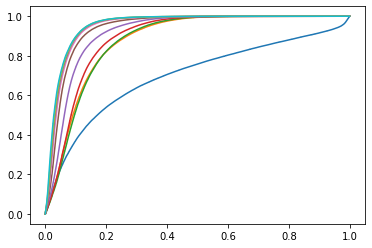

In [12]:
loss_train_arr = []
loss_val_arr = []
acc_arr = []
auc_arr = []
for e in range(epochs):
    label_pred = model(training_input)
    val_label_pred = model(val_input)
    
    loss_train = loss_fn(label_pred, training_labels.reshape(-1, 1))
    loss_val = loss_fn(val_label_pred, val_labels.reshape(-1, 1))
    
    acc_arr.append(1 - torch.sum(torch.abs(val_label_pred.round() - val_labels.reshape(-1, 1))).item()/len(val_labels))
    loss_train_arr.append(loss_train.item())
    loss_val_arr.append(loss_val.item())
    auc_arr.append(roc_auc_score(val_labels.detach().numpy(), val_label_pred.detach().numpy()))
    if e % 50 == 0:
        print("epoch: %d, loss: %.4f, accuracy: %.4f, AUC: %.4f" % (e, loss_train.item(), acc_arr[e], auc_arr[e]))
        fpr, tpr, thresholds = roc_curve(val_labels.detach().numpy(), val_label_pred.detach().numpy())
        plt.plot(fpr, tpr)  
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

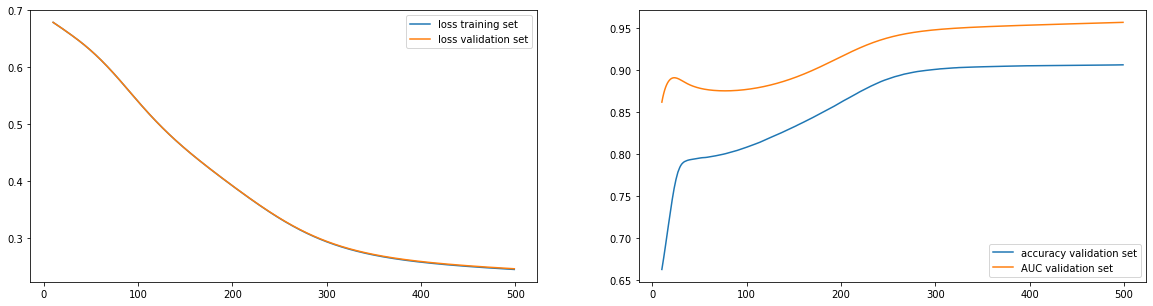

In [13]:
cut_epochs = 10

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.plot(range(epochs)[cut_epochs:], loss_train_arr[cut_epochs:], label='loss training set')
ax1.plot(range(epochs)[cut_epochs:], loss_val_arr[cut_epochs:], label='loss validation set')
ax1.legend(loc='upper right')
ax2.plot(range(epochs)[cut_epochs:], acc_arr[cut_epochs:], label='accuracy validation set')
ax2.plot(range(epochs)[cut_epochs:], auc_arr[cut_epochs:], label='AUC validation set')
ax2.legend(loc='lower right')
plt.show()